In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import image
from sklearn.metrics import f1_score, classification_report, precision_recall_fscore_support
import numpy as np
import pandas as pd
import cv2
import os
import csv
import pickle

In [2]:
def image_to_vector(image, size=(int(720/20),int(480/20))):
    image_array = cv2.imread(image)
    return cv2.resize(image_array, size).flatten()  # This is a numpy array

In [3]:
def get_image_list():
    image_list = []
    with open('/home/freija/Projects/birdometer/trainingdata/images.handscan.csv', 'r') as infile:
        reader = csv.reader(infile)
        for row in reader:
            image_list.append(row)
    return image_list

In [13]:
def get_label(image_detail):
    # The label needs to be 1 if image_detail[1]=='y' and 0 if not.
    if image_detail[1] == 'y':
        return 1
    elif image_detail[1] == 'n':
        return 0
    else:
        return -1  # Something is wrong

In [6]:
# Get the list of available training images
image_list = get_image_list()
print(len(image_list))

3860


In [7]:
# Extract the feature vectors for each image and store
features = []
labels = []
for image in image_list:
    image_path = '/home/freija/Projects/birdometer/trainingdata/' + image[0]
    label = get_label(image)
    # Ignore any label that is not 1 or 0
    # If the label is unknown, get_label returns -1 and the image
    # should be ignored
    if label != -1:
        features.append(image_to_vector(image_path))
        labels.append(get_label(image))

In [8]:
print(len(features), features[0])

3858 [160 134  93 ..., 134 114  81]


In [10]:
# Time to split up our data in a training, validation and test-set. We wanto to do 80%, 10%, 10%.
# We can call train_test_split twice. 
x, X_test, y, y_test = train_test_split(features,labels,test_size=0.2,train_size=0.8, random_state = 0)
X_train, X_cv, y_train, y_cv = train_test_split(x,y,test_size = 0.25,train_size =0.75, random_state = 0)
print(len(X_train), len(X_cv), len(X_test))

2314 772 772


# kNN with scikit-learn
The first algorithm to try is a simple Nearest-Neighbours one. The one parameter here is the
number of nearest neighbours to consider (k). We try k in [1,48[ range and test the F1 score on the validation set.

In [18]:
scores_cv = []
scores_train = []
for i in range(1,48):
    knn = KNeighborsClassifier(n_neighbors=i, algorithm = 'auto')
    knn.fit(X_train, y_train)
    # Get the predicted labels for the training set and the cross-validation set
    y_cv_pred = knn.predict(X_cv)
    y_train_pred = knn.predict(X_train)
    # Check the metrics
    precision_cv, recall_cv, f1_cv , _= precision_recall_fscore_support(y_cv, y_cv_pred)
    precision_train, recall_train, f1_train , _= precision_recall_fscore_support(y_train, y_train_pred)
    print(i, f1_cv, f1_train)
    scores_cv.append((precision_cv, recall_cv, f1_cv))
    scores_train.append((precision_train, recall_train, f1_train))

1 [ 0.9854851   0.91914894] [ 1.  1.]
2 [ 0.98176292  0.89473684] [ 0.98717949  0.93131868]
3 [ 0.98393267  0.91139241] [ 0.99175258  0.95721925]
4 [ 0.97653293  0.86098655] [ 0.9833887   0.90909091]
5 [ 0.97478992  0.85957447] [ 0.98613251  0.92643052]
6 [ 0.97334349  0.84848485] [ 0.98311157  0.90833333]
7 [ 0.97478992  0.85957447] [ 0.98305955  0.90983607]
8 [ 0.97486672  0.85714286] [ 0.9798212   0.88920056]
9 [ 0.97251908  0.84615385] [ 0.98104508  0.89779006]
10 [ 0.96808511  0.81578947] [ 0.97729013  0.87447109]
11 [ 0.97025172  0.83261803] [ 0.97927859  0.88734353]
12 [ 0.96588324  0.8       ] [ 0.97430679  0.85509326]
13 [ 0.96661608  0.80530973] [ 0.97553517  0.86363636]
14 [ 0.96515152  0.79464286] [ 0.97183456  0.83842795]
15 [ 0.96509863  0.79646018] [ 0.9727943   0.84604317]
16 [ 0.96363636  0.78571429] [ 0.96985052  0.82525698]
17 [ 0.96273764  0.7860262 ] [ 0.97051347  0.83285303]
18 [ 0.96133434  0.77333333] [ 0.96658228  0.80530973]
19 [ 0.96273764  0.7860262 ] [ 0.96

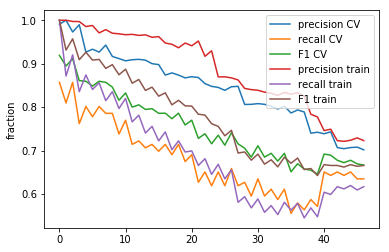

In [32]:
# We can plot the different metrics of the test and validation set as a function of k
import matplotlib.pyplot as plt
# Get the precisions for class 1 (there is a bird)
precision_cv = [x[1] for (x,y,z) in scores_cv]
recall_cv = [y[1] for (x,y,z) in scores_cv]
f1_cv = [z[1] for (x,y,z) in scores_cv]

precision_train = [x[1] for (x,y,z) in scores_train]
recall_train = [y[1] for (x,y,z) in scores_train]
f1_train = [z[1] for (x,y,z) in scores_train]

plt.plot(precision_cv)
plt.plot(recall_cv)
plt.plot(f1_cv)

plt.plot(precision_train)
plt.plot(recall_train)
plt.plot(f1_train)

plt.ylabel('fraction')
plt.legend(['precision CV', 'recall CV', 'F1 CV','precision train', 'recall train', 'F1 train'], loc='upper right')
plt.show()

In [33]:
knn = KNeighborsClassifier(n_neighbors=1, algorithm = 'auto')
knn.fit(X_train, y_train)
y_cv_pred = knn.predict(X_cv)
print(classification_report(y_cv, y_cv_pred))
type(classification_report(y_cv, y_cv_pred))

             precision    recall  f1-score   support

          0       0.97      1.00      0.99       646
          1       0.99      0.86      0.92       126

avg / total       0.98      0.98      0.97       772



str

In [40]:
f1_score(y_cv, y_cv_pred)

0.9152542372881356

# Neural Network with Tensorflow

In [10]:
import tensorflow as tf
# The labels need to be 1-hot encoded.. wich they are currently not. 
print(X_train[0].shape)

(2592,)


In [11]:
x = tf.placeholder(tf.float32, [None, 2592])
W = tf.Variable(tf.zeros([2592, 2]))
b = tf.Variable(tf.zeros([2]))
y = tf.nn.softmax(tf.matmul(x,W)+b)